# Common Crawl web graph statistics notebook

This notebook will guide you through how to:
- Load Common Crawl webgraph
- Generate statistics about said webgraph
- Interact with said webgraph

Requirements:
- Python
- For windows users, WSL
- AWS CLI
- Maven

### Note: Please refer to the [README](https://github.com/Xue-Alex/commoncrawl_notebooks/blob/master/README.md) and follow along here, as more details about each step will be provided in the README.

In [4]:
%%bash

git clone https://github.com/commoncrawl/cc-webgraph.git

cd cc-webgraph

mvn package;

First, we clone an existing repo, `cc-webgraph` which provides us with some very useful scripts that will help us get the webgraph set up. We run `mvn package` as the Java tools in this repo are compiled and packages with Maven.

In [27]:
%%bash

for f in cc-main-2020-feb-mar-may-domain-t.graph cc-main-2020-feb-mar-may-domain-t.properties \
         cc-main-2020-feb-mar-may-domain.graph cc-main-2020-feb-mar-may-domain.properties \
         cc-main-2020-feb-mar-may-domain.stats \
         cc-main-2020-feb-mar-may-domain-edges.txt.gz; do
   aws --no-sign-request s3 cp s3://commoncrawl/projects/hyperlinkgraph/cc-main-2020-feb-mar-may/domain/$f .;
done

We download the webgraph which is represented in the form of different files (such as `.graph`, `.stats`, etc). It should be noted that these files may be fairly large (and are also provided on the [blog](https://commoncrawl.org/2020/06/host-and-domain-level-web-graphs-febmarmay-2020/)).

In [ ]:
%%bash

WG="java -cp target/cc-webgraph-0.1-SNAPSHOT-jar-with-dependencies.jar"

This shell variable `WG` is the path to our jar file that will help us run the java commands

In [ ]:
%%bash

$WG it.unimi.dsi.webgraph.BVGraph -O -L cc-main-2020-feb-mar-may-domain
$WG it.unimi.dsi.webgraph.BVGraph -O -L cc-main-2020-feb-mar-may-domain-t

$WG it.unimi.dsi.webgraph.algo.ConnectedComponents -m --renumber --sizes -t cc-main-2020-feb-mar-may-domain-t cc-main-2020-feb-mar-may-domain
$WG it.unimi.dsi.webgraph.algo.StronglyConnectedComponents --renumber --sizes cc-main-2020-feb-mar-may-domain

We will now generate the offset files and connected component files of our webgraph

In [ ]:
%%bash

$WG it.unimi.dsi.webgraph.Stats --save-degrees cc-main-2020-feb-mar-may-domain

Finally, we may generate the stats file of our webgraph

In [ ]:
%%bash

cat 

Another interesting tool that you may look into is pyWebGraph, a program developed by Massimo Santini which interfaces Jython with WebGraph. This tool makes the exploration of WebGraphs very easy. The following sections will outline how to get started using pyWebGraph.

In [ ]:
%%bash

zcat cc-main-2020-feb-mar-may-domain-vertices.txt.gz \
  | cut -f2 \
  | $WG it.unimi.dsi.sux4j.mph.GOV4Function cc-main-2020-feb-mar-may-domain.mph
  
zcat cc-main-2020-feb-mar-may-domain-vertices.txt.gz \
  | cut -f2 \
  | $WG it.unimi.dsi.util.ShiftAddXorSignedStringMap cc-main-2020-feb-mar-may-domain.mph cc-main-2020-feb-mar-may-domain.smph
  
zcat cc-main-2020-feb-mar-may-domain-vertices.txt.gz \
  | cut -f2 \
  | $WG it.unimi.dsi.util.FrontCodedStringList -u -r 32 cc-main-2020-feb-mar-may-domain.fcl

In order to interact with the webgraph, we first need to [rebuild the string maps](http://law.di.unimi.it/tutorial.php)

In [ ]:
%%bash

git clone https://github.com/mapio/py-web-graph.git

cd py-web-graph

We clone [Massimo Santini's](https://santini.di.unimi.it/) repository, which provides a nice interface for the Web Graph.

In [ ]:
%%bash

wget https://repo1.maven.org/maven2/org/python/jython-standalone/2.7.2/jython-standalone-2.7.2.jar

The pyWebGraph repo operates on Jython, so we will download it (note that Jython is only compatible with Python 2).

In [ ]:
%%bash

cp pywebgraph/console.py .

DIR=$PWD

WEBGRAPH_VERSION="3.6.5"

Copying over the console file and defining a couple of shell variables, we may now move onto launching the console.

In [ ]:
%%bash

WG_CP=$DIR/webgraph-$WEBGRAPH_VERSION.jar:$(ls $DIR/deps/*.jar | tr '\n' ':')

We define the class path for the webgraph package. Note: Windows users should run the following command instead, as the pathing syntax is different.

In [ ]:
%%bash

WG_CP=$DIR/webgraph-$WEBGRAPH_VERSION.jar\;$(ls $DIR/deps/*.jar | tr '\n' ';')

In [ ]:
%%bash

java -Xmx12g -Dpython.console=org.python.util.JLineConsole -Dpython.executable=/bin/python2.7 -cp $WG_CP:../jython-standalone-2.7.2.jar: org.python.util.jython console.py

We will launch the pyWebGraph console! Again, Windows users should run only the following command due to syntactical differences.

In [ ]:
%%bash

java -Xmx12g -Dpython.console=org.python.util.JLineConsole -Dpython.executable=/bin/python2.7 -cp $WG_CP\;../jython-standalone-2.7.2.jar\; org.python.util.jython console.py

You should now see a console for pyWebGraph. Run `help` to view available commands. Refer to the README for an example!

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

We will be using `pandas` and `matplotlib` to manipulate and visualize some interesting statistics about the webgraph!

In [7]:
graph_name = "../cc-webgraph/output_dir/cc-main-2020-feb-mar-may-domain"

Specify the path to the graph of interest. This may vary, depending on which crawl you would like to investigate.

In [8]:
#List of extensions that should be plotted
metric_extensions = ['indegree','outdegree', 'sccdistr']
weakly_cc = "-connected-components-distrib.txt.gz"

Here, `metric_extensions` is a list of extensions of the files that we will be plotting. All of these files have the same format, which is a list of frequency values, where the i'th value has the number of nodes with indegree/outdegree of i.

`weakly_cc` contains information about strongly and weakly connected components, which is formatted differently (list of tuples containing <frequency,size,percent coverage of the graph>.

In [9]:
#Use pandas to manipulate frequency tables
def generate_df(metric):
    df = pd.read_table(graph_name + "." + metric,header=None,names=['frequency'])
    return df

Helper function that uses `pandas` to read in our files as dataframes, for faster processing.

In [10]:
#Collect and clean frequency tables of indegree, outdegree and sccdistr
#Note that 0 must be removed as this will be plotted on a log log graph
df_list = []
for metric in metric_extensions:
    generated_df = generate_df(metric)
    generated_df = generated_df.iloc[lambda x: x.index != 0]
    generated_df = generated_df[generated_df['frequency'] > 0]
    df_list.append([generated_df,metric])

We load up all of our data into seperate dataframes, and remove the values of "0" due to the fact that we will be plotting on a loglog graph.

In [11]:
#Load up all connected component distribution, which has unique header info so must be done seperately
df = pd.read_table(graph_name + weakly_cc, header=None, names=['size','percent_coverage']).sort_index()

In [12]:
#Remove header
df = df.iloc[1:]

In [13]:
#Convert data to int rather than string so it may be plotted
df.index = df.index.astype(int)
df['size'] = df['size'].astype(int)

We will load up the connected component file seperately, due to the fact that it is formatted differently.

In [14]:
#Add processed connected component distribution table to list of all tables that will be plotted
df_list.append([df,'allccdistr'])

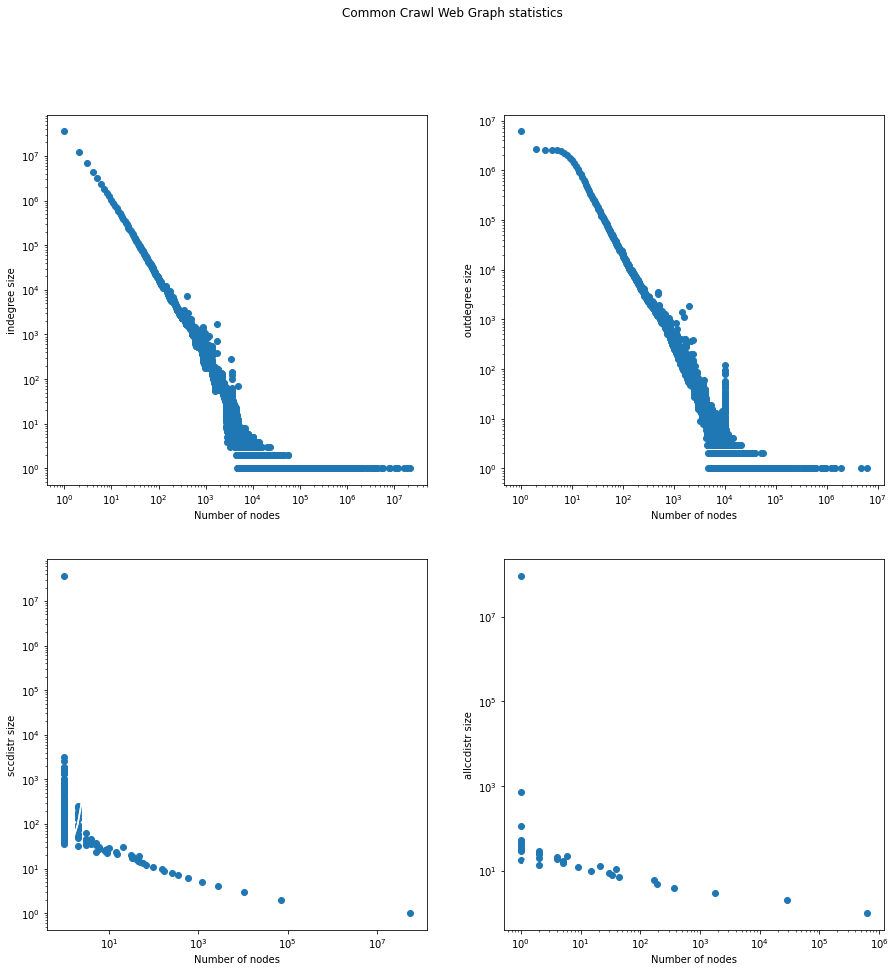

In [26]:
plt_list = [0]*4
fig, ((plt_list[0], plt_list[1]), (plt_list[2], plt_list[3])) = plt.subplots(2, 2)
fig.suptitle('Common Crawl Web Graph statistics')
fig.set_figheight(15)
fig.set_figwidth(15)
graph_number = 0
for df_pair in df_list:
    df = df_pair[0]
    metric = df_pair[1]
    #We will plot this on a log log graph
    plt_list[graph_number].semilogy([1,10,100,1000,10000,100000,1000000], color='white')
    plt_list[graph_number].semilogx([1,10,100,1000,10000,100000,1000000], color='white')
    
    #Based on how our data is formatted we will plot on different x and y
    if metric == "sccdistr":
        plt_list[graph_number].scatter(df['frequency'], df.index)
    elif metric == "allccdistr":
        plt_list[graph_number].scatter(df.index, df['size'])
    else:
        plt_list[graph_number].scatter(df.index, df['frequency'])
    
    plt_list[graph_number].set(xlabel = "Number of nodes", ylabel = metric + " size")
    graph_number += 1


Finally, we may visualize these dataframes. Iterating over the list of dataframes that we have created, we will plot them on a loglog graph one by one, and for each different suffix (sccdistr, allcdistr, outdegree, indegree) we may or may not plot them differently. 